# Surf quality prediction in Kattegat
## For scoring better surf: being at the right spot at the right time

In [3]:
import requests #for requesting weather and ocean data
import pandas as pd
import datetime as dt
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xarray as xr
#import pygrib

Wave surfing is 
a weather dependent action sport. There are many factors that come into play to be 
able to achieve good surf, i.e., quality waves that are surfable. Obviously, each surf 
spot needs different wind, wave and water level conditions to deliver good surf, and 
although we may easily find out and know about good surf spots it is difficult to 
understand on which ambient said weather conditions, the best waves will be avail-
able. 
Weather data and forecasting services are available online for the prediction of these 
best wave conditions. However, even small changes in wind angles, tidal changes, 
wind speed and duration, can determine if the waves will be great or horrible. This 
is especially true for surf spots in the coastal areas of Sweden and Finland. 
This model aims to better predict the surf conditions for surf spots in south-western 
Sweden. The idea is to use readily available historical weather data, on wind time 
and location dependent speed and direction and sea level and past user experience 
data, to teach the model to identify when the surf is going to be great. 

### Danish weather data is used

Six timestamped features from Anholt weather station 
• Wind speed 
• Wind direction 
• Average wind speed previous hour 
• Average wind direction previous hour 
• Maximum wind within the 10-minute time frame 
• Pressure at sea level 

The weather data has been retrieved from the Danish Meteorological Institute open 
data, which provides free open observed weather data from various weather station 
including Anholt, an island located in Kattegat Sea

Wave model parameters

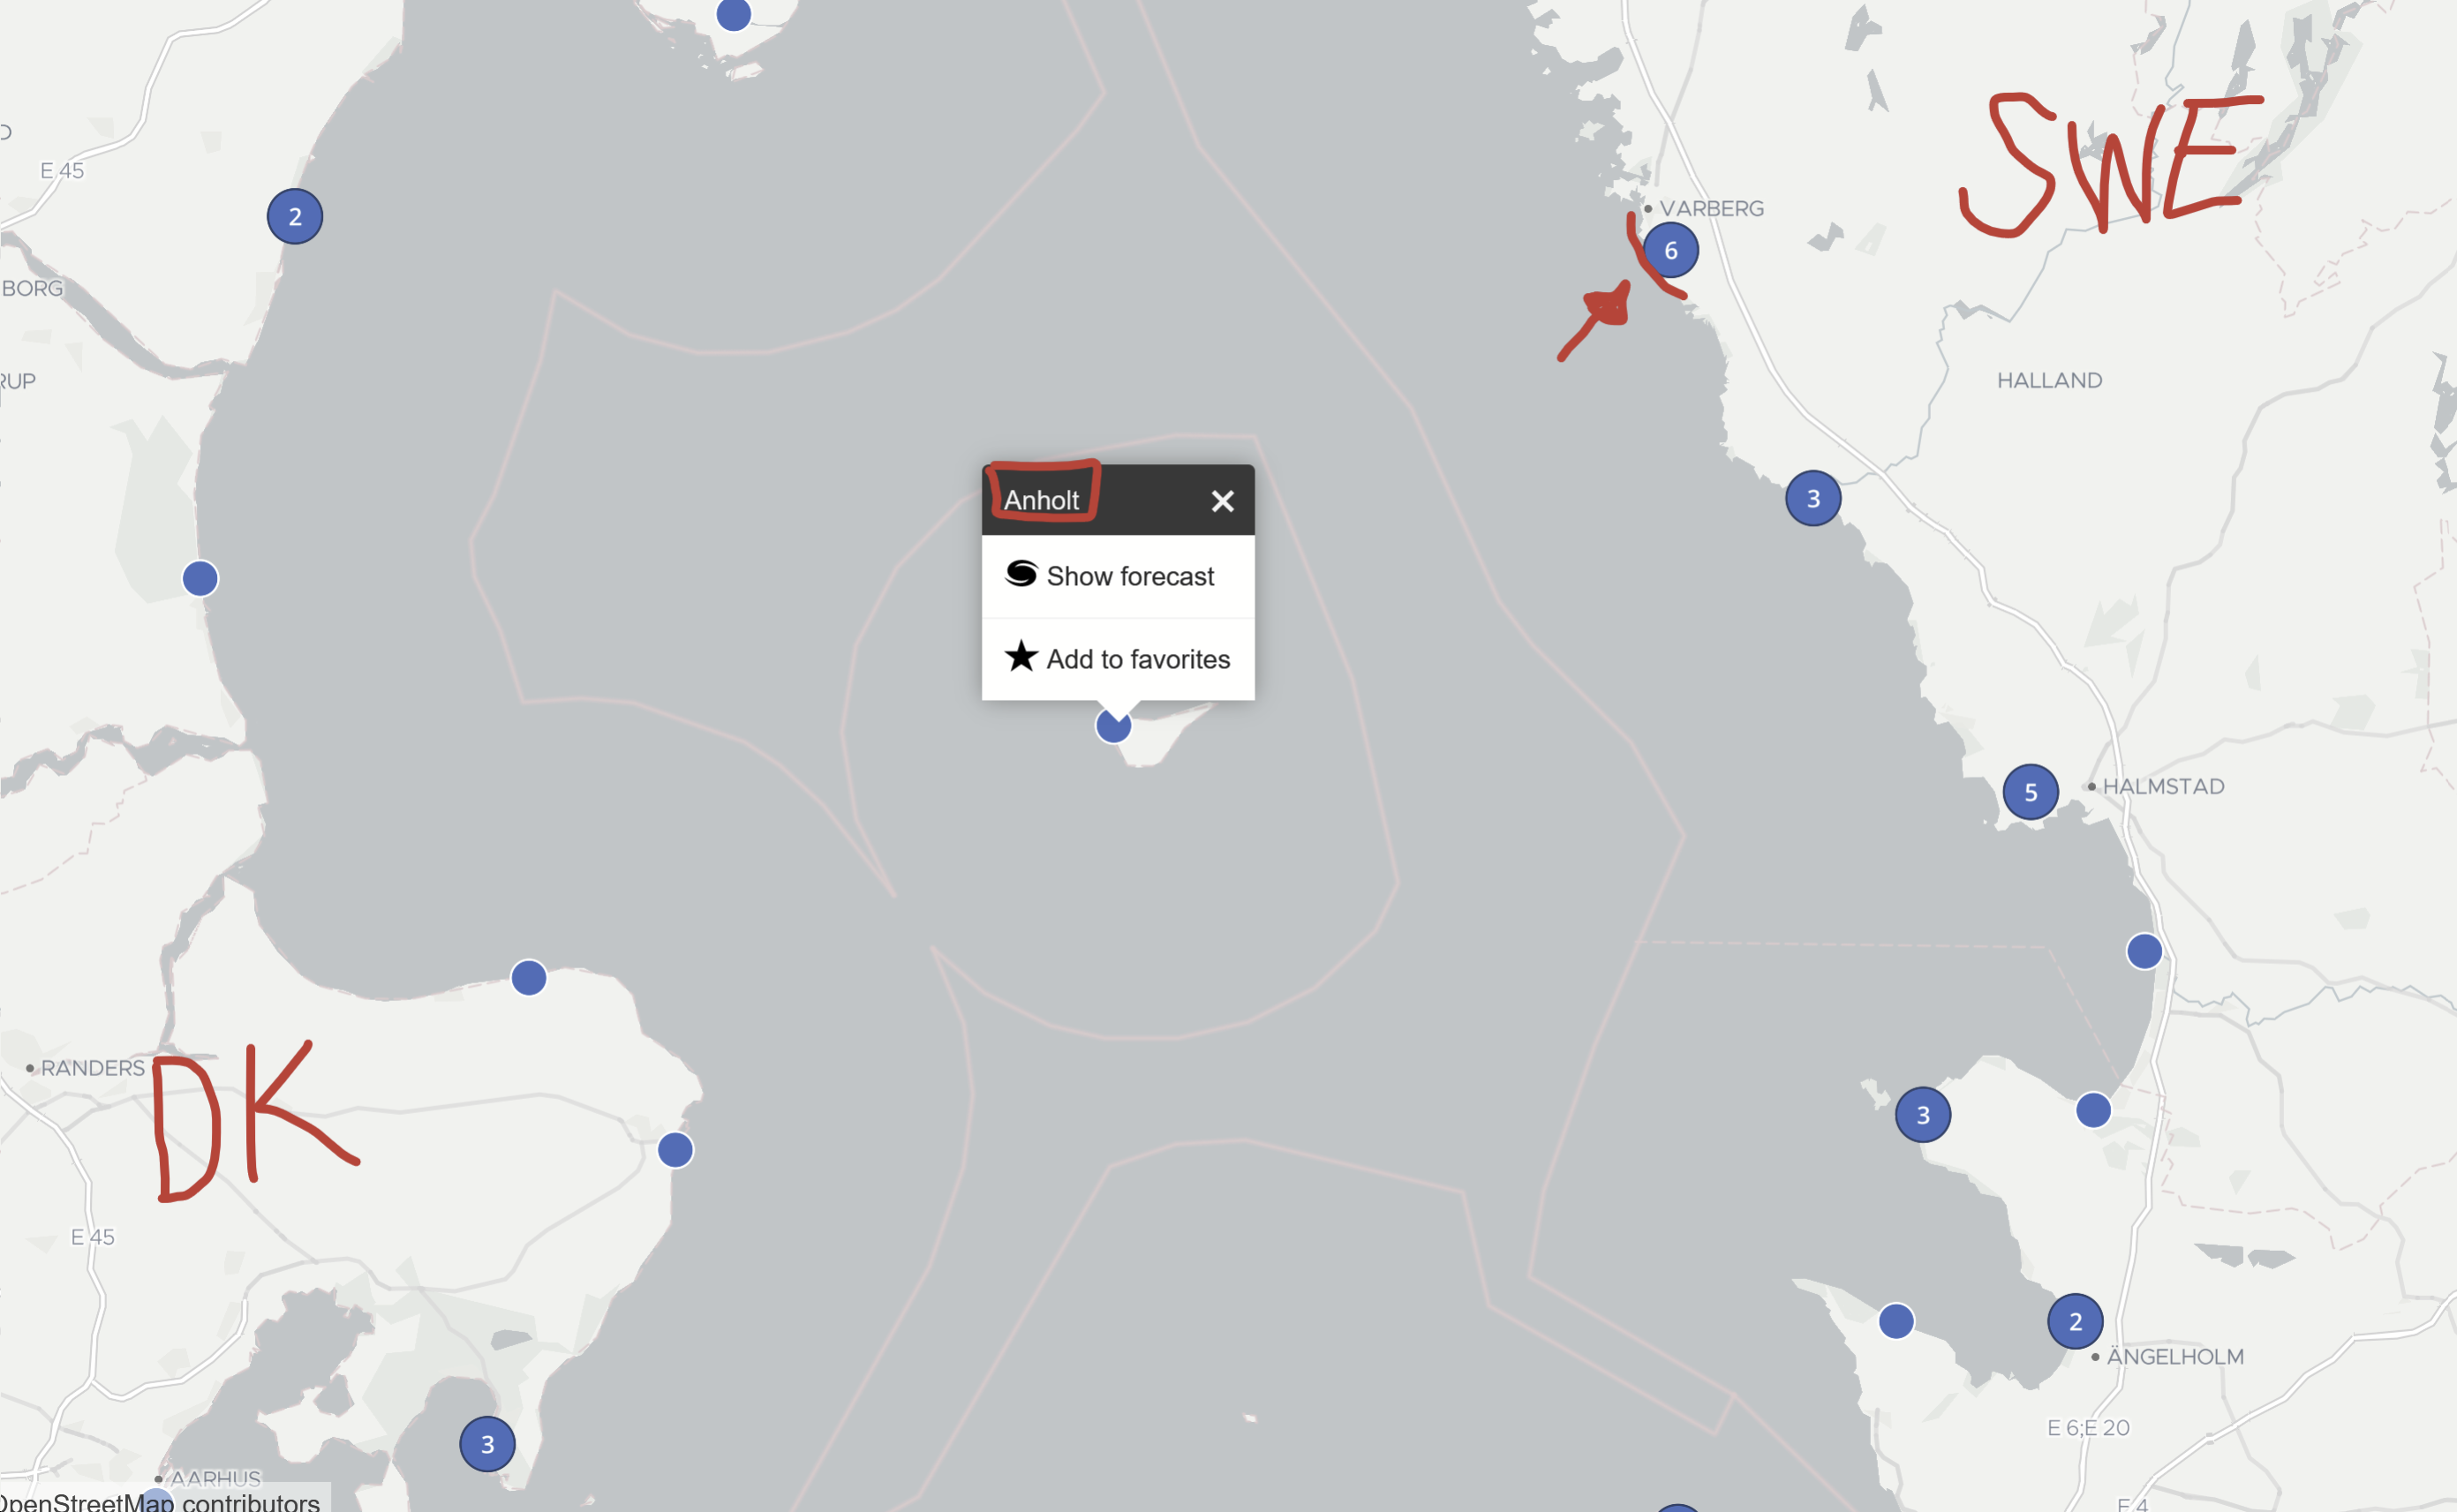



In [4]:
#API URLs and keys for DMI requests

api_key = '38d68b9b-c88f-4429-a5b6-0aa3cd565e7e' #API key from requesting DMI (Danish meterological institute) weather data
api_keyObs = '6eb4d132-2bc8-413c-a19a-310b447dbc07' #Api key for observed weather data
api_key_forecast = '3c6c7681-c254-4038-bbe4-3e1796357b7c' #API key for forecasting data DMI
api_key_edr = '5113209d-ee57-4070-a4a6-7fafd8cd858b' #API key for forecasting edr
api_key_ocean = '9e6aee57-e414-4ce9-9809-4183d6dda7d8' #API key for ocean data DMI
DMI_URL_ocean ='https://dmigw.govcloud.dk/v2/oceanObs/api/' #request link ocean without parameters
DMI_URL_only =' https://dmigw.govcloud.dk/v2/metObs/collections/observation/items' #request link without parameters
DMI_URL = 'https://dmigw.govcloud.dk/v2/metObs/api'
DMI_Forecast = 'https://dmigw.govcloud.dk/v1/forecastedr/api' #request link for forecast
DMI_ForecastWAMDW = 'https://dmigw.govcloud.dk/v1/forecastedr/collections/wam_dw/items' #request link for wam in danish waters


In [5]:
stationIds = ['06079'] # Anholt weather station id
stationGrena = ['22121'] # Grenå sea level observation station

# Specify the desired start and end time
start_time = pd.Timestamp(2023, 9, 19)
end_time = pd.Timestamp(2023, 9, 21)
print('start time: '+ start_time.strftime('%d/%m/%Y, %H:%M') +'\nend time: ' + end_time.strftime('%d/%m/%Y, %H:%M'))

start time: 19/09/2023, 00:00
end time: 21/09/2023, 00:00


Wind speed and direction and how they change are the two most important factors 
determining the quality of surf. However other factors like sea level, can elevate (or 
escalate) wave quality from good to excellent (or vice versa). Sea level data is not 
recorded as often. In the Baltic Sea, lunar and solar tidal changes are neglectable 
and water level depends mostly on wind and pressure. Therefore, pressure is added 
to the features. Not only is current wind speed and direction important, but how 
consistent and how long has the wind-blown from a certain direction. Waves are 
formed by the wind and wave power can be described by two parameters: wave 
height and wavelength (or period). Therefore past 1h wind data is also added to the 
features. The weather data is requested through DMI api services:


In [29]:
# Getting the past real time wind and pressure data

# Specify one or more parameter IDs or all_parameters
parameterIds = ['wind_dir', 'wind_speed','wind_dir_past1h','wind_speed_past1h','wind_max','wind_max_per10min_past1h','pressure_at_sea']

# Derive datetime specifier string
datetime_str = start_time.tz_localize('UTC').isoformat() + '/' + end_time.tz_localize('UTC').isoformat()
#datetime_str = start_time.tz_localize(None).isoformat() + '/' + end_time.tz_localize(None).isoformat()

#Setting up the data in a pandas dataframe. Instructions from DMI website: 
dfs = []
for station in stationIds:
    for parameter in parameterIds:
        # Specify query parameters
        params = {
            'api-key' : api_keyObs,
            'datetime' : datetime_str,
            'stationId' : station,
            'parameterId' : parameter,
            'limit' : '1000',  # max limit
        }

        # Submit GET request with url and parameters
        r = requests.get(DMI_URL_only, params=params)
        # Extract JSON object
        json = r.json() # Extract JSON object
        #print(r)
        # Convert JSON object to a MultiIndex Pandas DataFrame and add to list
        dfi = pd.json_normalize(json['features'])
        #print(dfi.keys())
        if dfi.empty is False:
            #dfi['time'] = pd.to_datetime(dfi['properties.observed'])
            dfi['time'] = dfi['properties.observed'] #Setting time index, without datetime format, since not supported by excel export
            dfi[['station', 'parameter']] = station, parameter
            
            dfi = dfi.set_index(['parameter', 'station', 'time'])
            
            dfi = dfi['properties.value'].unstack(['station','parameter'])
           
            dfs.append(dfi)

df = pd.concat(dfs, axis='columns').sort_index()
df = df.reset_index()

df.head()
df.tail()

station                    time    06079                             \
parameter                       wind_dir wind_speed wind_dir_past1h   
284        2023-12-20T23:20:00Z    254.0       10.4             NaN   
285        2023-12-20T23:30:00Z    253.0       10.5             NaN   
286        2023-12-20T23:40:00Z    254.0        9.3             NaN   
287        2023-12-20T23:50:00Z    254.0        9.3             NaN   
288        2023-12-21T00:00:00Z    254.0        9.0           253.0   

station                                                                        
parameter wind_speed_past1h wind_max wind_max_per10min_past1h pressure_at_sea  
284                     NaN     13.0                      NaN           992.5  
285                     NaN     12.5                      NaN           992.3  
286                     NaN     11.3                      NaN           992.3  
287                     NaN     11.6                      NaN           992.2  
288                     9.8     11.0                     10.8           992.1

In [192]:
df.to_excel('WindInfo.xlsx')

## Data labels

Labels are added by myseld manually (Any ideas how this could be done elegantly?)

- 0 (no surf), 
- 1 (very small), 
- 2 (some open sections),
- 4 (good to very good), 
- 5 (the best possible for the spot) 

 

The labels are created by the user (myself). The user surfed the spot on both days 
for 4 hours a day when the quality reached from 1 (in the morning of 19th) to 5 in the 
during the daytime of the same day. For zero value labels the following applies: 
• If the wind speed is below 9 the quality is 0. 
• If the wind direction is higher than 270 degrees, or lower than 150 degrees 
the quality is zero. 

In [39]:
quality_data = pd.read_excel('WaveQuality_2023091920.xlsx') 
# Read the user wave quality data, with the same time index as the other dataframes
print(quality_data['Quality'].head())

df['Quality']=quality_data['Quality']


0    0
1    0
2    0
3    0
4    0
Name: Quality, dtype: int64


In [31]:
df_hourly = df.fillna(method='ffill')
df_hourly = df_hourly.drop(('06079','wind_max_per10min_past1h'),axis=1)
df_hourly.head()

/tmp/ipykernel_486/211835488.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_hourly = df.fillna(method='ffill')


station                    time    06079                             \
parameter                       wind_dir wind_speed wind_dir_past1h   
0          2023-12-19T00:00:00Z    246.0        9.8           234.0   
1          2023-12-19T00:10:00Z    250.0        9.6           234.0   
2          2023-12-19T00:20:00Z    252.0        9.3           234.0   
3          2023-12-19T00:30:00Z    253.0        9.6           234.0   
4          2023-12-19T00:40:00Z    252.0        9.5           234.0   

station                                              Quality  
parameter wind_speed_past1h wind_max pressure_at_sea          
0                       8.9     11.8          1007.7       0  
1                       8.9     11.2          1007.9       0  
2                       8.9     11.0          1007.9       0  
3                       8.9     11.1          1008.0       0  
4                       8.9     11.3          1008.0       0

## Visualization of data

Figures below shows the different features and the recorded surf quality. A spe-
cific pattern is difficult to observe, however it seems that the stronger the wind the 
better the surf has been. Also, for the surf to be great, the wind needs to blow from 
a specific direction.

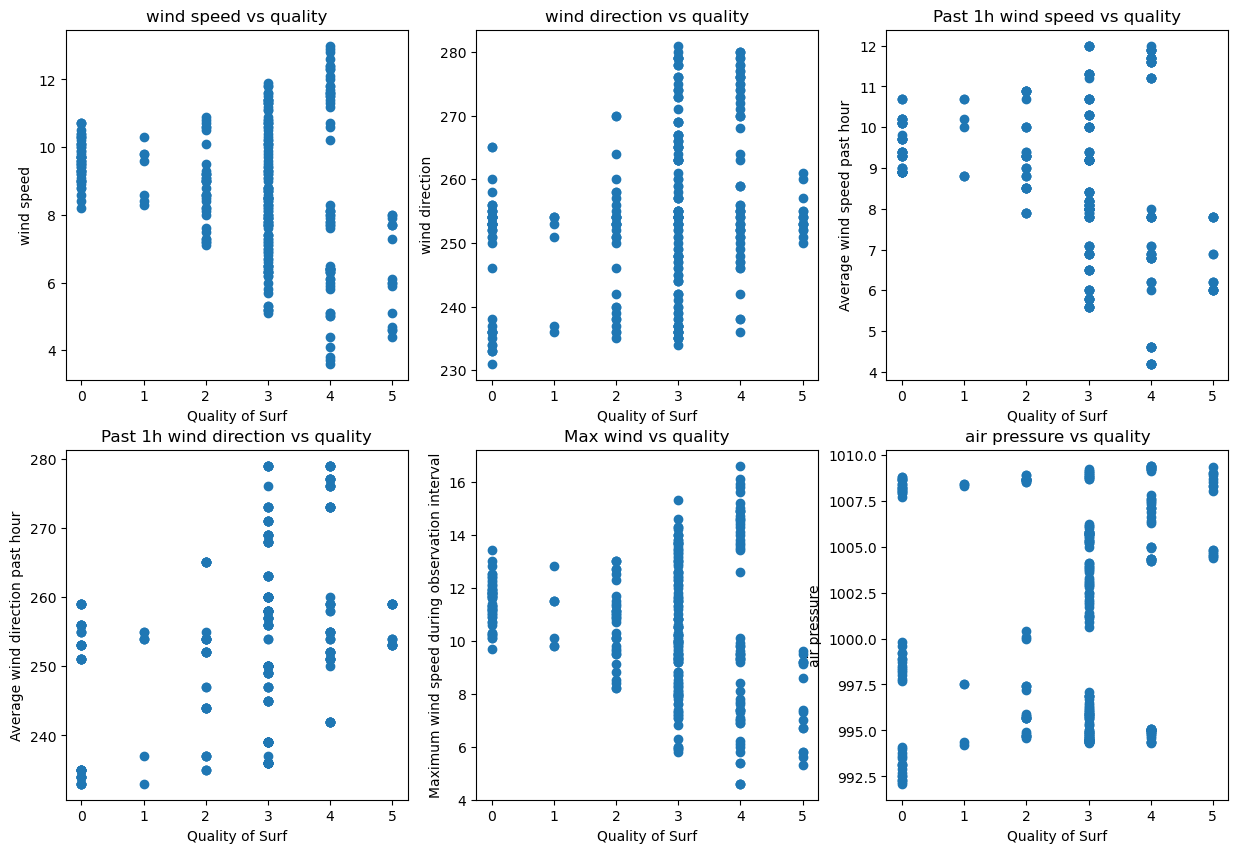

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0][0].scatter(df_hourly['Quality'],df_hourly['06079']['wind_speed']);
axes[0][0].set_xlabel("Quality of Surf")
axes[0][0].set_ylabel("wind speed")
axes[0][0].set_title("wind speed vs quality")

axes[0][1].scatter(df_hourly['Quality'],df_hourly['06079']['wind_dir']);
axes[0][1].set_xlabel("Quality of Surf")
axes[0][1].set_ylabel("wind direction")
axes[0][1].set_title("wind direction vs quality")

axes[0][2].scatter(df_hourly['Quality'],df_hourly['06079']['wind_speed_past1h']);
axes[0][2].set_xlabel("Quality of Surf")
axes[0][2].set_ylabel("Average wind speed past hour")
axes[0][2].set_title("Past 1h wind speed vs quality")

axes[1][0].scatter(df_hourly['Quality'],df_hourly['06079']['wind_dir_past1h']);
axes[1][0].set_xlabel("Quality of Surf")
axes[1][0].set_ylabel("Average wind direction past hour")
axes[1][0].set_title("Past 1h wind direction vs quality")

axes[1][1].scatter(df_hourly['Quality'],df_hourly['06079']['wind_max']);
axes[1][1].set_xlabel("Quality of Surf")
axes[1][1].set_ylabel("Maximum wind speed during observation interval")
axes[1][1].set_title("Max wind vs quality")

axes[1][2].scatter(df_hourly['Quality'],df_hourly['06079']['pressure_at_sea']);
axes[1][2].set_xlabel("Quality of Surf")
axes[1][2].set_ylabel("air pressure")
axes[1][2].set_title("air pressure vs quality")
plt.show()

## The labels and quality of surf

The quality scale is continuous, and the difference between, for example a 3- and a 
4-quality surf could seem minimal. This means only a slight change in wind speed 
or direction could have different outcomes.  


The figure below shows the number of times a certain quality has been observed. As 
explained in the section above one observation is a 10-minute interval. The time the 

(array([ 48.,   7.,  35., 123.,  76.]),
 array([0., 1., 2., 3., 4., 5.]),
 <BarContainer object of 5 artists>)

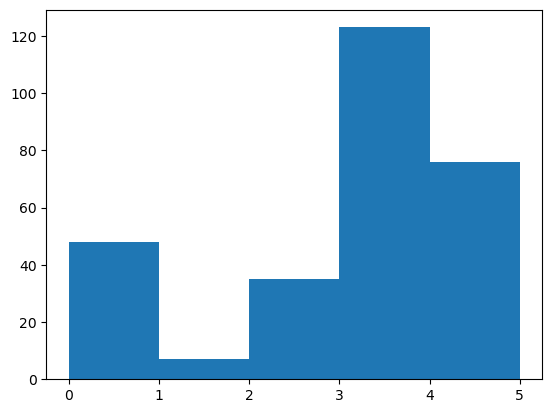

In [33]:
plt.hist(df_hourly['Quality'],bins=5)

## Training the artificial neural network model

In [34]:
# The dataset is divided into feature matrix X and label vector y for the model
X = df_hourly['06079'].to_numpy()
y = df_hourly['Quality'].to_numpy()
print(X.shape)
print(y.shape)

(289, 6)
(289,)


In [35]:
#Splitting the data into training and validation
X_train, X_val,  y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [36]:
#Using the similar method as from the course exercises

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, accuracy_score

## define a list of values for the number of hidden layers
num_layers = [1,2,4,6,8,10]    # number of hidden layers
num_neurons = 12  # number of neurons in each layer


# we will use this variable to store the resulting training errors corresponding to different hidden-layer numbers
mlp_tr_errors_12 = []          
mlp_val_errors_12 = []

for i, num in enumerate(num_layers):
    hidden_layer_sizes = tuple([num_neurons]*num) # size (num of neurons) of each layer stacked in a tuple

    mlp_regr = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,random_state=42,max_iter=1000) # Initialise an MLPRegressor
 
    mlp_regr.fit(X_train,y_train)   # Train MLP on the training set
    
    
    ## evaluate the trained MLP on both training set and validation set
    y_pred_train = mlp_regr.predict(X_train)    # predict on the training set
    tr_error = mean_squared_error(y_train, y_pred_train)    # calculate the training error
    y_pred_val = mlp_regr.predict(X_val) # predict values for the validation data 
    val_error = mean_squared_error(y_val, y_pred_val) # calculate the validation error
    
    # sanity check num of layers
    assert mlp_regr.n_layers_ == num_layers[i]+2 # total layers = num of hidden layers + input layer + output layer

    
    mlp_tr_errors_12.append(tr_error)
    mlp_val_errors_12.append(val_error)

# sanity check the length of array mlp_tr_errors
print(mlp_tr_errors_12)
print(mlp_val_errors_12)

[51.92188931150481, 45.60474784520307, 18.9990212831588, 4.608708365909191, 1.8706117941775353, 1.874858809248509]
[43.45047091557742, 44.96832109163686, 21.06447385369625, 5.625233383625064, 2.292226936458188, 2.376216703518719]


In [37]:
#Using the similar method as from the course exercises

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix


## define a list of values for the number of hidden layers
num_layers = [1,2,4,6,8,10]    # number of hidden layers
num_neurons = 15  # number of neurons in each layer


# we will use this variable to store the resulting training errors corresponding to different hidden-layer numbers
mlp_tr_errors_15_neurons = []          
mlp_val_errors_15_neurons = []

for i, num in enumerate(num_layers):
    hidden_layer_sizes = tuple([num_neurons]*num) # size (num of neurons) of each layer stacked in a tuple

    mlp_regr = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,random_state=42,max_iter=1000) # Initialise an MLPRegressor
 
    mlp_regr.fit(X_train,y_train)   # Train MLP on the training set
    
    
    ## evaluate the trained MLP on both training set and validation set
    y_pred_train = mlp_regr.predict(X_train)    # predict on the training set
    tr_error = mean_squared_error(y_train, y_pred_train)    # calculate the training error
    y_pred_val = mlp_regr.predict(X_val) # predict values for the validation data 
    val_error = mean_squared_error(y_val, y_pred_val) # calculate the validation error
    
    # sanity check num of layers
    assert mlp_regr.n_layers_ == num_layers[i]+2 # total layers = num of hidden layers + input layer + output layer

    mlp_tr_errors_15_neurons.append(tr_error)
    mlp_val_errors_15_neurons.append(val_error)

# sanity check the length of array mlp_tr_errors
print(mlp_tr_errors_15_neurons)
print(mlp_val_errors_15_neurons)

[25.068095405732183, 3.2318769352566923, 4.401780718240304, 1.7453429576480723, 2.2190370299097713, 1.844067116465047]
[24.06428560532034, 3.8448962682387546, 5.289684046658891, 2.329796732296252, 2.461867222259513, 2.2525875710696917]


In [38]:
#Using the similar method as from the course exercises

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, accuracy_score

## define a list of values for the number of hidden layers
num_layers = [1,2,4,6,8,10]    # number of hidden layers
num_neurons = 20  # number of neurons in each layer


# we will use this variable to store the resulting training errors corresponding to different hidden-layer numbers
mlp_tr_errors_20_neurons = []          
mlp_val_errors_20_neurons = []

for i, num in enumerate(num_layers):
    hidden_layer_sizes = tuple([num_neurons]*num) # size (num of neurons) of each layer stacked in a tuple

    mlp_regr = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,random_state=42,max_iter=1000) # Initialise an MLPRegressor
 
    mlp_regr.fit(X_train,y_train)   # Train MLP on the training set
    
    
    ## evaluate the trained MLP on both training set and validation set
    y_pred_train = mlp_regr.predict(X_train)    # predict on the training set
    tr_error = mean_squared_error(y_train, y_pred_train)    # calculate the training error
    y_pred_val = mlp_regr.predict(X_val) # predict values for the validation data 
    val_error = mean_squared_error(y_val, y_pred_val) # calculate the validation error
    
    # sanity check num of layers
    assert mlp_regr.n_layers_ == num_layers[i]+2 # total layers = num of hidden layers + input layer + output layer

    
    mlp_tr_errors_20_neurons.append(tr_error)
    mlp_val_errors_20_neurons.append(val_error)

# sanity check the length of array mlp_tr_errors
print(mlp_tr_errors_20_neurons)
print(mlp_val_errors_20_neurons)

[15.149804477898517, 9.827469625190401, 2.294688913195179, 1.8045096945817425, 2.0419754004946955, 1.9044785838500757]
[18.072597071558494, 9.36961378233928, 2.849602967205249, 2.1879464242837234, 2.6280827606535433, 2.36892998652227]


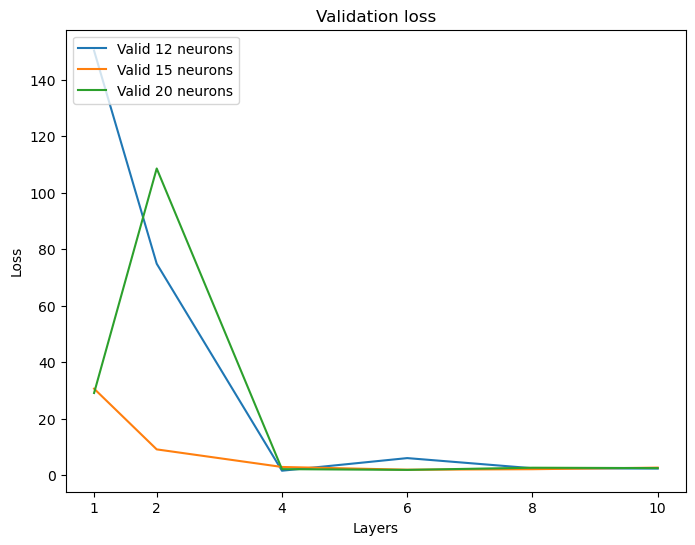

In [309]:
plt.figure(figsize=(8, 6))

plt.plot(num_layers, mlp_val_errors_12, label = 'Valid 12 neurons')
plt.plot(num_layers, mlp_val_errors_15_neurons,label = 'Valid 15 neurons')
plt.plot(num_layers, mlp_val_errors_20_neurons,label = 'Valid 20 neurons')
plt.xticks(num_layers)
plt.legend(loc = 'upper left')

plt.xlabel('Layers')
plt.ylabel('Loss')
plt.title('Validation loss')
plt.show()


In [310]:
errors = {"num_hidden_layers":num_layers,
          "mlp_val_errors_12N":mlp_val_errors_12,
          "mlp_val_errors_15N":mlp_val_errors_15_neurons,
          "mlp_val_errors_20N":mlp_val_errors_20_neurons
         }
errors_df = pd.DataFrame(errors)
errors_df

,num_hidden_layers,mlp_val_errors_12N,mlp_val_errors_15N,mlp_val_errors_20N
0,1,150.212479,30.570306,29.038250
1,2,74.808130,9.080441,108.520050
2,4,1.525986,2.856045,2.085445
3,6,5.993522,1.881156,1.822690
4,8,2.409749,2.059965,2.590067
5,10,2.293234,2.625447,2.455395


In [293]:
errors_df.to_excel('errors.xlsx')